In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
%matplotlib inline
le = preprocessing.LabelEncoder()
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [78]:
# Загрузим данные
data= pd.read_csv('data.txt', delimiter=';', encoding='cp1251') 

# Данные не имеют пропусков и сильных выбрасов
# Преобразуем данные ( сделаем бинизацию) 

def default (row):
    if row['Флаг дефолта по кредиту']=='Нет дефолта':
        return 1
    if row['Флаг дефолта по кредиту']=='Дефолт':
        return 0
    
def children (row):
    if row['Наличие детей у клиента']=='Детей нет':
        return 0
    else:
        return 1
    
def default (row):
    if row['Флаг дефолта по кредиту']=='Нет дефолта':
        return 0
    else:
        return 1


def client (row):
    if row['Является ли клиентом банка']=='Не клиент банка':
        return 0
    else:
        return 1

def sex (row):
    if row['Пол клиента']=='Мужской':
        return 0
    else:
        return 1

def age (row):
    if 20< row['Возраст клиента']<=25 :
        return '20-25'
    if 25< row['Возраст клиента']<=30 :
        return '25-30'
    if 30< row['Возраст клиента']<=45 :
        return '30-45'
        
    else:
        return '>40'
    
def good (row):
    if row['Тип товара'] =='Мобильные телефоны' :
        return 'Мобильные телефоны'
    if row['Тип товара'] =='Бытовая техника' :
        return 'Бытовая техника'
    if row['Тип товара'] =='Мебель' :
        return 'Мебель'
    if row['Тип товара'] =='Компьютеры, комплектующие' :
        return 'Компьютеры, комплектующие'        
    else:
        return 'rest'

def income (row):
    if row['Доход клиента']< 10000:
        return '<10k'
    if 10000<= row['Доход клиента']<=20000 :
        return '10-20k'
    if 20000<= row['Доход клиента']<=40000 :
        return '20-40k'
    if 40000<= row['Доход клиента']<=70000 :
        return '40-70k'

    else:
        return '>70k' 

def credit (row):
    if row['Сумма кредита']< 10000:
        return '<10k'
    if 10000<= row['Сумма кредита']<=20000 :
        return '10-20k'
    if 20000<= row['Сумма кредита']<=40000 :
        return '20-40k'
    if 40000<= row['Сумма кредита']<=70000 :
        return '40-70k'

    else:
        return '>70k'
    
def payment_to_income (row):
    if row['Платеж к доходу']< 10:
        return '<10%'
    if 10<= row['Платеж к доходу']<50 :
        return '10-50%'

    else:
        return '>50%'

def term (row):
    if row['Срок кредита']<= 12:
        return 'до 12'
    if 12< row['Срок кредита']<=24 :
        return '12-24'

    else:
        return '>24'

# создадим функцию для веротяностей Weight of evidence. 
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    
    return df_train, df_test    



# Применим функции к нашему датасету.
data['Платеж к доходу']=data['Сумма кредита']/data['Срок кредита']*100//data['Доход клиента']
data['Флаг дефолта по кредиту']=data.apply(default, axis=1)
data['Возраст клиента']=data.apply(age, axis=1)
data['Тип товара']=data.apply(good, axis=1)
data['Доход клиента']=data.apply(income, axis=1)
data['Срок кредита']=data.apply(term, axis=1)
data['Сумма кредита']=data.apply(credit, axis=1)
data['Платеж к доходу']=data.apply(payment_to_income, axis=1)


In [79]:
# Проверим насколько равномерно разибили данные
for i in data.columns:
    k=data[i].unique()
    for p in k:
        print(i, p, len(data[data[i]==p]))

Месяц выдачи кредита 1 139
Месяц выдачи кредита 2 138
Месяц выдачи кредита 3 158
Месяц выдачи кредита 4 131
Месяц выдачи кредита 5 116
Месяц выдачи кредита 6 122
Месяц выдачи кредита 7 145
Месяц выдачи кредита 8 142
Месяц выдачи кредита 9 136
Месяц выдачи кредита 10 160
Месяц выдачи кредита 11 174
Месяц выдачи кредита 12 162
Сумма кредита <10k 238
Сумма кредита 10-20k 554
Сумма кредита 20-40k 619
Сумма кредита 40-70k 198
Сумма кредита >70k 114
Срок кредита до 12 1363
Срок кредита 12-24 314
Срок кредита >24 46
Возраст клиента 30-45 577
Возраст клиента >40 443
Возраст клиента 20-25 369
Возраст клиента 25-30 334
Пол клиента Мужской 931
Пол клиента Женский 792
Образование клиента Среднее специальное 836
Образование клиента Высшее 585
Образование клиента Неоконченное высшее 86
Образование клиента Среднее 208
Образование клиента Неоконченное среднее 5
Образование клиента Несколько высших или более высокая ступень образования 3
Тип товара Мобильные телефоны 498
Тип товара Бытовая техника 471


In [80]:
# В итоге получился датасет следующим:
data.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту,Платеж к доходу
0,1,<10k,до 12,30-45,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,20-40k,Другое,МТС,Не клиент банка,0,<10%
1,1,10-20k,до 12,>40,Мужской,Среднее специальное,Бытовая техника,Дети есть,Другие регионы,10-20k,Другое,Теле2,Клиент банка,0,10-50%
2,1,20-40k,до 12,20-25,Женский,Среднее специальное,Бытовая техника,Детей нет,Другие регионы,20-40k,Другое,Билайн,Не клиент банка,0,<10%
3,1,10-20k,до 12,25-30,Мужской,Среднее специальное,Мобильные телефоны,Дети есть,Другие регионы,20-40k,Никогда не был(а) женат/замужем,Теле2,Клиент банка,0,<10%
4,1,10-20k,до 12,20-25,Женский,Высшее,Мобильные телефоны,Детей нет,Другие регионы,20-40k,Женат/замужем,МТС,Клиент банка,0,<10%


In [81]:
cat_columns = [col for col in data.columns if data[col].dtype == 'object']
#data=pd.get_dummies(data, cat_columns)

In [82]:
# Разобьем данные равномерно по группам данных и проверим флаг дефолта в трейне и тесте

from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(data, data['Флаг дефолта по кредиту']):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['Флаг дефолта по кредиту'].iloc[train_index]
    y_test = data['Флаг дефолта по кредиту'].iloc[test_index]
print('Доля дефолтов в тесте составляет',len(d_test[d_test['Флаг дефолта по кредиту']==1])*100//len(d_test), '%')
print('Доля дефолтов в трейне составляет',len(d_train[d_train['Флаг дефолта по кредиту']==1])*100//len(d_train), '%')

Доля дефолтов в тесте составляет 11 %
Доля дефолтов в трейне составляет 11 %


In [83]:
#  Применим функцию WOE  
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
for categorical_columns in categorical_columns:
    d_train, d_test = get_woe_v1(d_train, d_test, categorical_columns, 'Флаг дефолта по кредиту')

In [84]:
# оставим только числовые переменные woe, убрав преоразованные категориальные данные
categorical_columns = [col for col in d_train.columns if d_train[col].dtype == 'object']
d_train=d_train.drop(categorical_columns,axis=1)
d_test=d_test.drop(categorical_columns,axis=1)

In [85]:
# Проверим, чтобы не было корелляций между признаками
d_train.corr()

,Месяц выдачи кредита,Флаг дефолта по кредиту,Сумма кредита_woe,Срок кредита_woe,Возраст клиента_woe,Пол клиента_woe,Образование клиента_woe,Тип товара_woe,Наличие детей у клиента_woe,Регион выдачи кредита_woe,Доход клиента_woe,Семейное положение_woe,Оператор связи_woe,Является ли клиентом банка_woe,Платеж к доходу_woe
Месяц выдачи кредита,1.000000,0.019717,-0.086592,-0.027773,-0.011211,0.023780,-0.032246,-0.045016,0.012854,0.010414,-0.078062,-0.022967,-0.017946,-0.026383,0.014143
Флаг дефолта по кредиту,0.019717,1.000000,0.038125,0.050831,0.070467,0.098071,0.149475,0.236002,0.065640,0.057052,0.046191,0.036307,0.055071,0.087822,0.078344
Сумма кредита_woe,-0.086592,0.038125,1.000000,-0.197613,0.137328,0.109220,0.101663,0.192749,0.027714,0.078188,0.098755,0.022588,0.005074,0.003895,0.230000
Срок кредита_woe,-0.027773,0.050831,-0.197613,1.000000,-0.033387,-0.028831,-0.084517,-0.109843,-0.042670,-0.018530,-0.027916,0.003714,0.000296,-0.035475,0.070473
Возраст клиента_woe,-0.011211,0.070467,0.137328,-0.033387,1.000000,0.223000,-0.068651,0.126135,0.194434,0.011449,0.041633,-0.003750,-0.006706,0.011850,0.148044
Пол клиента_woe,0.023780,0.098071,0.109220,-0.028831,0.223000,1.000000,0.122979,0.142490,0.101580,-0.018824,-0.099787,-0.046546,0.055596,0.035377,0.174805
Образование клиента_woe,-0.032246,0.149475,0.101663,-0.084517,-0.068651,0.122979,1.000000,0.171698,-0.002794,0.160009,0.174143,-0.040866,0.054384,0.061933,0.010218
Тип товара_woe,-0.045016,0.236002,0.192749,-0.109843,0.126135,0.142490,0.171698,1.000000,0.076728,0.011204,0.073167,0.041038,0.049715,0.093989,0.153833
Наличие детей у клиента_woe,0.012854,0.065640,0.027714,-0.042670,0.194434,0.101580,-0.002794,0.076728,1.000000,-0.091398,0.006880,0.006325,0.017582,0.104774,0.010523
Регион выдачи кредита_woe,0.010414,0.057052,0.078188,-0.018530,0.011449,-0.018824,0.160009,0.011204,-0.091398,1.000000,0.160030,-0.008277,-0.010632,0.030316,-0.039973


In [86]:
#d_train.to_excel('d_train.xls')

In [87]:
# Уберем флаги дефолта из трейна и теста.
del d_train['Флаг дефолта по кредиту']
del d_test['Флаг дефолта по кредиту']

In [88]:
# Появилсь пропущенные значения от функции woe, там где флага дефолта=0 не было.
# Заменим пропущенные зачения медианами
from sklearn.preprocessing import Imputer 
mean_imputer_y = Imputer()
da_train = mean_imputer_y.fit_transform(d_train)
da_test = mean_imputer_y.transform(d_test)

In [60]:
# Обработка готова. 
# Значений немного, выборка небольшая, поэтому здесь в качестве 
# математической модели воспользуемся логистической регрессией
# Запустим поиск оптимальных параметров 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':(0.001, 10, 0.1), 'tol':(0.001,10, 0.1), 'max_iter':((1,100,10)) }
lr=LogisticRegression(random_state=42)
clf = GridSearchCV(lr, parameters)
clf.fit(da_train, y_train)
print(clf.score(da_train, y_train))
print(clf.score(da_test, y_test))

0.8867924528301887
0.8869565217391304


In [61]:
clf.best_params_

{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.1}

In [62]:
# При данных параметрах, видим, что не произошло 
# переобучения и получился хороший результат 0.8869
lr=LogisticRegression(C=10, penalty='l2', tol=0.1, max_iter=100, random_state=42)
lr.fit(da_train, y_train)
print(lr.score(da_test, y_test))
print(lr.score(da_train, y_train))

0.8869565217391304
0.8867924528301887


In [77]:
lr.coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [100]:
# попробуем улучшить результаты с помощью полиномиальных признаков во второй степени.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
daa_train= poly.fit_transform(da_train)
daa_test= poly.transform(da_test)

#poly2 the best results with woe and without usual columns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':(0.001, 10, 0.1), 'tol':(0.001,10, 0.1), 'max_iter':((1,100,10)) }
lr=LogisticRegression(random_state=42)
clf = GridSearchCV(lr, parameters)
clf.fit(daa_train, y_train)
print(clf.score(daa_test, y_test))
print(clf.score(daa_train, y_train))

0.8898550724637682
0.8867924528301887


In [65]:
# В итоге видим, что результат улучшился на 0.0029 и составил 0.8898
print(classification_report(y_test, clf.predict(da_test)))
print(accuracy_score(y_test, clf.predict(da_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94       306
          1       0.67      0.05      0.10        39

avg / total       0.87      0.89      0.85       345

0.8898550724637682


In [91]:
da_train.fillna(0)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [101]:
# Для тестирования, проверим работу деревьев решений. Для этого запустим поиск параметров
parameters = {
            'max_depth': [1, 2, 5, 10, 20, 100],
            'n_estimators': [1, 5, 10, 20, 50, 100]}

rfc = RandomForestClassifier(random_state=42)
clfR = GridSearchCV(rfc, parameters)
clfR.fit(daa_train, y_train)
print(clfR.score(daa_test, y_test))
print(clfR.score(daa_train, y_train))

0.8869565217391304
0.886066763425254


In [98]:
print(classification_report(y_test, clfR.predict(da_test)))
print(accuracy_score(y_test, clfR.predict(da_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94       306
          1       0.00      0.00      0.00        39

avg / total       0.79      0.89      0.83       345

0.8869565217391304


In [68]:
# Запустим CatBoost. Но результат все равно показывает худший, чем логистическая регрессия.
#params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#          'iterations':[1,2,3,4,5,6,7,8,9,10],
#          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#          'l2_leaf_reg':[3,1,5,10,100]}
#
#cbc = CatBoostClassifier(random_state=42)
#cb = GridSearchCV(cbc, params)
#cb.fit(d_train, y_train)
#print(cb.score(d_test, y_test))
#print(cb.score(d_train, y_train))

In [117]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(depth= 9, iterations= 10, l2_leaf_reg= 5, learning_rate= 0.3,random_state=42)
cbc.fit(d_train, y_train)
print(cbc.score(d_test, y_test))
print(cbc.score(d_train, y_train))

0:	learn: 0.4603112	total: 30.2ms	remaining: 272ms
1:	learn: 0.3771892	total: 47.3ms	remaining: 189ms
2:	learn: 0.3461185	total: 56.8ms	remaining: 133ms
3:	learn: 0.3282042	total: 65.9ms	remaining: 98.9ms
4:	learn: 0.3171575	total: 89.7ms	remaining: 89.7ms
5:	learn: 0.3080523	total: 99.3ms	remaining: 66.2ms
6:	learn: 0.2968866	total: 157ms	remaining: 67.1ms
7:	learn: 0.2917857	total: 165ms	remaining: 41.3ms
8:	learn: 0.2889010	total: 174ms	remaining: 19.3ms
9:	learn: 0.2740588	total: 195ms	remaining: 0us
0.881159420289855
0.8889695210449927


Test:
ROC AUC: 0.6978
Train:
ROC AUC: 0.8582


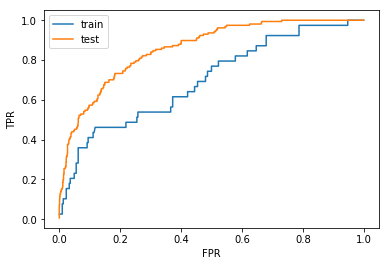

In [118]:
print('Test:')
calc_auc(y_test, y_pred_cbc, 'train')
print('Train:')
calc_auc(y_train, y_pred_cbc_train, 'test')


plt.legend();

In [104]:
#y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_cbc = cbc.predict_proba(d_test)[:, 1]
y_pred_cbc_train = cbc.predict_proba(d_train)[:, 1]
y_pred_clfR = clfR.predict_proba(d_test)[:, 1]
y_pred_clfR = cbcR.predict_proba(d_test)[:, 1]



CatboostError: catboost/libs/model/model_pool_compatibility.cpp:49: Feature 17 is present in model but not in pool.

In [105]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

Test:
ROC AUC: 0.6978
Train:
ROC AUC: 0.8582


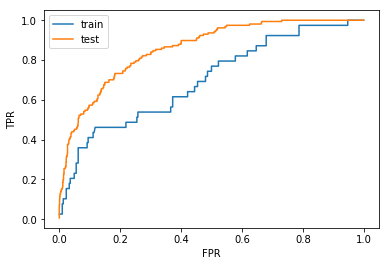

In [ ]:
print('Tedfsdfst:')
calc_auc(y_test, y_pred_clfR, 'te33455st')
print('Tessafast:')
calc_auc(y_test, y_pred_clf, 'tes777t')

Train:
ROC AUC: 0.7908
Test:
ROC AUC: 0.7473


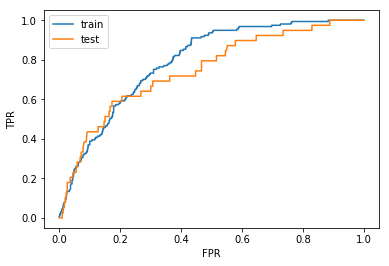

In [113]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
clf_ada = AdaBoostClassifier()

clf_ada.fit(da_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(da_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(da_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.legend();